#**Convolutional Neural Network**
The problem we are trying to solve here is to classify grayscale images of handwritten objects (28 pixels by 28 pixels), into 10 categories (apple, banana, fork...). 

The dataset we will use is extracted from the Kaggle competition: **Quick Draw! Doodle Recognition Challenge ** (https://www.kaggle.com/c/quickdraw-doodle-recognition). This dataset contains 

#**1. Notebook Setting**

Import Pytorch and Python libraries (Numpy, Matplotlib...)

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  
import numpy as np
import os
import sys
import torch
import torchvision
import random
import codecs
import torch.utils.data
import torch.optim as optim
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import datasets, transforms

print('Done!')

In [0]:
#Training on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# **2. Dataset Preparation**

Download, reduce, reshape and reorganize dataset


## **2.1 Download the Dataset:**

The dataset is downloaded from the Google APIs and it comes in the form of a set of Numpy arrays.

In [0]:
  urls = [
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/key.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/banana.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tennis%20racquet.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pizza.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/stop%20sign.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wheel.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fork.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy',
        'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/apple.npy',
    ]
  
  class_name = ['key', 'banana', 'ladder', 'tennis_racquet', 'pizza', 'stop_sign', 'wheel', 'fork', 'book', 'apple']
   
  def createDir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    
  def gen_bar_updater(pbar):
    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)
    return bar_update   
    
  def download_url(url, root, filename):
      from six.moves import urllib
      root = os.path.expanduser(root)
      fpath = os.path.join(root, filename + ".npy")

      createDir(root)

      # downloads file
      if os.path.isfile(fpath):
          a = 1
          #print('Using downloaded and verified file: ' + fpath)
      else:
          try:
              print('Downloading ' + url + ' to ' + fpath)
              urllib.request.urlretrieve(
                  url, fpath,
                  reporthook = gen_bar_updater(tqdm(unit='B', unit_scale=True))
              )
          except OSError:
              if url[:5] == 'https':
                  url = url.replace('https:', 'http:')
                  print('Failed download. Trying https -> http instead.'
                        ' Downloading ' + url + ' to ' + fpath)
                  urllib.request.urlretrieve(
                      url, fpath,
                      reporthook = gen_bar_updater(tqdm(unit='B', unit_scale=True))
                  )
                  
                  
                  
  for i in range(0, len(urls)):
    download_url(urls[i], "data", class_name[i])
    
    
  print("Done!")   

## **2.2 Reduction, reshape and reorganization of the Dataset:**

In [0]:
class_name = ['apple', 'banana', 'book', 'fork', 'key', 'ladder', 'pizza', 'stop_sign', 'tennis_racquet', 'wheel']
step = ['train', 'validation', 'test']

dire = r'data/'

max_length = 10000 # Maximum number of files (drawings) per class
percen=[0.6, 0.3, 0.1] # Percentage of training, validation and testing

begin = [0, int(max_length * percen[0]), int(max_length * (percen[0] + percen[1])) + 1]
end = [int(max_length * (percen[0])), int(max_length * (percen[0] + percen[1])) + 1, max_length]

for c in range(0, len(class_name)):
  print('Class ' + str(c+1) + ' out of ' + str(len(class_name)))
  filename = dire + str(class_name[c]) + '.npy'
  data = np.load(filename)
  
  for s in range(0, len(step)):
    dire_step = str(dire) + str(step[s])
    if not os.path.exists(dire_step):
      os.makedirs(dire_step)
    
    for i in range(begin[s], end[s]):
      dire_class = str(dire_step) + '/' + str(class_name[c])
      if not os.path.exists(dire_class):
        os.makedirs(dire_class)
      
      # Reshape the raw data into 28x28 images
      data_sample = data[i,:].reshape((28, 28))
      sample_name = class_name[c] + '_' + str(step[s]) + '_' + str(i)
      np.save(os.path.join(dire_class, sample_name), data_sample)

print('Done!')

## **2.3 Dataset Visualization:**

Visualization of a random image corresponding to the training set of images of the selected class. 

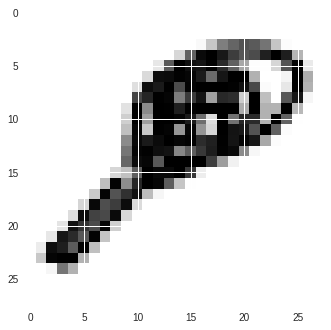

In [0]:
drawing_class = 8  # 0-apple, 1-banana, 2-book, 3-fork, 4-key, 5-ladder, 6-pizza, 7-stop_sign, 8-tennis_racquet, 9-wheel
image_number=random.randint(1,max_length*percen[0])
dire = r'data/train/' + str(class_name[drawing_class]) + '/' + str(class_name[drawing_class]) + '_' + 'train' + '_' + str(image_number) +'.npy'
data = np.load(dire)
plt.imshow(data)
plt.show()

# **3. Network Definition**

##**3.1 Mini-batch definition**

In [0]:
def load_sample(x):
	return np.load(x)


bs = 32
train_dir = r"data/train"
val_dir = r"data/validation"
test_dir = r"data/test"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.DatasetFolder(train_dir, extensions = ['.npy'], loader = load_sample)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = bs, shuffle = True, num_workers = 2)
train_iter = iter(train_loader)

valid_dataset = datasets.DatasetFolder(train_dir, extensions = ['.npy'], loader = load_sample)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size = bs, shuffle = True, num_workers = 2)
valid_iter = iter(train_loader)

test_dataset = datasets.DatasetFolder(test_dir, extensions = ['.npy'], loader = load_sample)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = bs, shuffle = True, num_workers = 2)
test_iter = iter(test_loader)

batch, labels = train_iter.next()
print(batch.size())

## **3.2 CNN definition and Forward Pass**

In [0]:
class Net(nn.Module):
  
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding = 1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        
        self.conv2 = nn.Conv2d(6, 16, 3, padding = 1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 16, 3, padding = 1)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        
        self.conv4 = nn.Conv2d(16, 32, 3, padding = 1)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        
        self.conv5 = nn.Conv2d(32, 32, 3, padding = 1)
        torch.nn.init.xavier_uniform_(self.conv5.weight)
        
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = F.relu(self.conv5(x))
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

net = Net()
net.to(device)
print(net)

## **3.3 Loss Function and Optimizer Definition**

As it is a classification, we have chosen to used the Cross Entropy Loss. As the optimizer we will use the Gradient Descent algorithm, having the learning rate and momentum as hyperparameters.

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.000001)

# **4. Network Training**

In [0]:
# To plot the results
training_loss_list = []
validation_loss_list = []


for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs = inputs.view(bs,1,28,28).float()
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] Training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            training_loss_list.append(running_loss/200)
            running_loss = 0.0
            
            with torch.no_grad():
              valid_inputs, valid_labels = valid_iter.next()
              valid_inputs = valid_inputs.view(bs, 1, 28, 28).float()
              valid_inputs = valid_inputs.to(device)
              valid_labels = valid_labels.to(device)
              valid_outputs = net(valid_inputs)
              valid_loss = criterion(valid_outputs, valid_labels)
              print('[%d, %5d] Validation loss: %.3f' %
                  (epoch + 1, i + 1, valid_loss))
              validation_loss_list.append(valid_loss)
            

print('Finished Training')

In [0]:
import numpy as np
import matplotlib.pyplot as plt

training_examples = 6e5
plot_every = 200 #batches
training_loss_np = np.asarray(training_loss_list)
validation_loss_np = np.asarray(validation_loss_list)

x_axis = np.arange(0, len(training_loss_list))
plt.plot(x_axis * bs * plot_every / training_examples, training_loss_np)
plt.plot(x_axis * bs * plot_every / training_examples, validation_loss_np)
plt.show()

# **5. Network Testing**

In [0]:
!nvidia-smi

In [0]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

print('GroundTruth: ', ' '.join('%5s' % class_name[labels[j]] for j in range(4)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_name[predicted[j]] for j in range(4)))

Let's evaluate the model on the test data:

While our densely-connected network we had a test accuracy of 97.8%, our basic convnet has a test accuracy of 99.3%: we decreased our error rate by 68% (relative).

In [0]:
# ACCURACY OF THE NETWORK
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [0]:
#WHICH CLASSESS PERFORMED BETTER
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

**Coses que falten:**

1.   Fer proves hiperparametres/tamany xarxa/arquitectura per millorar el train
2.   Afegir plots de les losses, accuracy
3.   Afegir final st
4.   Redactar tots els apartats



